# Goals of the practical session:
- Understand a mimimal Python code implementing a memory efficient logistic regression from scratch. 
- Adapt the code to obtain some common features such as a quadratic kernel and a regularization.
- Learn how to conveniently track and measure the performances of a set of models with several hyper parameters. 

# Part I: Logistic regression from scratch

Download some data from a recent challenge
- [Small version](http://go.criteo.net/criteo-ppml-challenge-adkdd21-dataset.zip) (284 Mo, more than enough for today)
- [Complete version](http://go.criteo.net/criteo-ppml-challenge-adkdd21-dataset-raw-granular-data.csv.gz) (optional aditionnal data if you want to try different things - 50Go)

For convience here it is a few batch commands downloading and extracting data in your drive:


In [1]:
!wget http://go.criteo.net/criteo-ppml-challenge-adkdd21-dataset.zip
!unzip criteo-ppml-challenge-adkdd21-dataset.zip
!rm aggregated_noisy_data_pairs.csv.gz aggregated_noisy_data_singles.csv.gz
!gunzip X_test.csv.gz X_train.csv.gz y_test.csv.gz y_train.csv.gz
!rm criteo-ppml-challenge-adkdd21-dataset.zip

In [6]:
!sed -n 1,10000p X_test.csv > X_valid.csv #CARE we took 10k lines from test as validation.
!sed -n 1,10000p y_test.csv > y_valid.csv
!mv *.csv ../data/

A quick look to the 10 first rows of the data shows there is 19 categorical features already hashed as integers. All of them are related to the proability of a click event and are related to observed events of a user either on a publisher website, either on an advertiser website. The large dataset correspond to one day of data on one platform. 

Form the small dataset, it is possible to directly use almost any software able to perform a logistic regression. Depending on your hardware you may run in troubles for the large one (in fact with the large one vowpal wabbit will do it, but strugles to achieve the optimization of the loss). 

Today our first goal is to understand a minimal version of a logistic regression coded from scratch in Python.


In [9]:
from datetime import datetime
from csv import DictReader
from math import exp, log, sqrt


# parameters #################################################################

X_train = '../data/X_train.csv'  # path to training files
y_train = '../data/y_train.csv'


D = 2 ** 20   # max number of weights to use (hash size)
alpha = .1    # learning rate for sgd optimization


# function definitions #######################################################

# A. Bounded logloss
# INPUT:
#     p: our prediction
#     y: real answer
# OUTPUT
#     logarithmic loss of p given y
def logloss(p, y):
    p = max(min(p, 1. - 10e-12), 10e-12)
    return -log(p) if y == 1. else -log(1. - p)


# B. Apply hash trick of the original csv row
# for simplicity, we treat both integer and categorical features as categorical
# INPUT:
#     csv_row: a csv dictionary, ex: {'hash_1': '357', 'hash_2': '', ...}
#     D: the max index that we can hash to
# OUTPUT:
#     x: a list of indices that its value is 1
def get_x(csv_row, D):
    x = []
    for key, value in csv_row.items():
        index = int(value + key[4:], 16) % D 
        x.append(index)
    return x  # x contains indices of features that have a value of 1


# C. Get probability estimation on x
# INPUT:
#     x: features
#     w: weights
# OUTPUT:
#     probability of p(y = 1 | x; w)
def get_p(x, w):
    wTx = 0.
    for i in x:  # do wTx
        wTx += w[i] * 1.  # w[i] * x[i], but if i in x we got x[i] = 1.
    return 1. / (1. + exp(-max(min(wTx, 20.), -20.)))  # bounded sigmoid


# D. Update given model
# INPUT:
#     w: weights
#     n: a counter that counts the number of times we encounter a feature
#        this is used for adaptive learning rate
#     x: feature
#     p: prediction of our model
#     y: answer
# OUTPUT:
#     w: updated model
#     n: updated count
def update_w(w, n, x, p, y):
    for i in x:
        # alpha / (sqrt(n) + 1) is the adaptive learning rate heuristic
        # (p - y) * x[i] is the current gradient
        # note that in our case, if i in x then x[i] = 1
        w[i] -= (p - y) * alpha / (sqrt(n[i]) + 1.)
        n[i] += 1.
    return w, n


# training and testing #######################################################

# initialize our model
w = [0.] * D  # first order parameters
n = [0.] * D  # number of times we've encountered a feature

# start training a logistic regression model using on pass sgd
loss = 0.
for t, (row, y)  in enumerate(zip(DictReader(open(X_train)), DictReader(open(y_train)))):
    # main training procedure
    # step 1, get the hashed features
    x = get_x(row, D)

    # step 2, get prediction
    p = get_p(x, w)
    target = float(y['click'])

    # for progress validation, useless for learning our model
    loss += logloss(p, target)
    if t % 10000 == 0 and t > 1:
        print('%s\tencountered: %d\tcurrent logloss: %f' % (
            datetime.now(), t, loss/t))

    # step 3, update model with answer
    w, n = update_w(w, n, x, p, target)

2022-01-05 19:06:06.445895	encountered: 10000	current logloss: 0.287254
2022-01-05 19:06:06.723408	encountered: 20000	current logloss: 0.270824
2022-01-05 19:06:07.012383	encountered: 30000	current logloss: 0.265079
2022-01-05 19:06:07.273940	encountered: 40000	current logloss: 0.265768
2022-01-05 19:06:07.583211	encountered: 50000	current logloss: 0.265401
2022-01-05 19:06:07.855401	encountered: 60000	current logloss: 0.265177
2022-01-05 19:06:08.155093	encountered: 70000	current logloss: 0.264792
2022-01-05 19:06:08.429358	encountered: 80000	current logloss: 0.262718
2022-01-05 19:06:08.714704	encountered: 90000	current logloss: 0.261705
2022-01-05 19:06:08.998164	encountered: 100000	current logloss: 0.260590


*Remark that is implementation is pure Python and quite fast while Python  is inefficient with loops without using just in time compilation. It will also handle the large dataset using a controlled memory footprint (around 200 Mo).*


**Questions**
1. 
Is it a good value for the loss? It may be convenient to answer such questions to compute statistics on the data. For this we are going to use numpy. If not already familiar you can find a [ref card](https://www.utc.fr/~jlaforet/Suppl/python-cheatsheets.pdf). There exist an [other one](http://mathesaurus.sourceforge.net/matlab-numpy.html) if you are already familiar with matlab.

In [11]:
import numpy as np
y = np.genfromtxt('../data/y_train.csv', delimiter=',', skip_header=1)
#-- Answer --
# First remark that with two classes a uniform random prediction would get is -log(1/2) ~ 0.693
# Bur logloss of a dummy prediction always answering the average value 
y_mean = y[:,0].mean()
Hy =  -y_mean * log( y_mean) - (1-y_mean) *log(1-y_mean)
print( Hy )
# ~ 0.3239
# So 0.26 is better than random but is only better by 20% w.r.t dummy predictor 

0.32391451592115916




2. What is doing the
```
int(value + key[4:], 16) % D
```

**-Answer-**

It is computing an index into 1..D, this is used as the memory emplacement to store the parameter corresponding to the value of $x_i$. Performances would be better with a larger value of D (default for Vopal Wabbit is $2^{24}$). This is a weak hash and it would be possible to replace it by a non cryptographic hashkey computation such as [Murmur](https://en.wikipedia.org/wiki/MurmurHash) and/or to use actual hashtable to store the values of the parameters without collision. Note that in some applications reducing the number of collisions can reduce slightly the logloss and this will always be slower.   

3. Do we have an intercept term (if not how to add it) ? 



In [12]:
#Answer
#There is no intercept in the current code.
#See answer to question 5 for a clean addition of it using the position 0 from the array of parameters (could be any other position). This does not impact significantly the loss 

4. Implement a validation score using the X_valid.csv, y_valid.csv data on a fraction of test data using a  [Normalized Cross Entropy](https://www.nist.gov/system/files/documents/2017/11/30/nce.pdf). $$ NCE = (H(y) - Logloss)/H(y) $$ where H(y) is Shannon entropy of y computed in the natural basis (2 may be a better choice but as we computed the log loss in the natural basis, it is better to keep using it).

Now allows to iterate several times accoss the dataset 10 times. Are you overfitting?

In [13]:
#First note that we in fact computer the entropy of y at question 1 and it is better to avoid to recompute it at each call
#It may be better to compute it on the complete dataset but train is good enough and faster 

#y_data = np.genfromtxt('y_train.csv', delimiter=',', skip_header=1)
#y_mean = y_data[:,0].mean()
#Hy = -y_mean * log( y_mean) - (1-y_mean) *log(1-y_mean)


X_valid = '../data/X_valid.csv'
y_valid = '../data/y_valid.csv'

D = 2 ** 20   
alpha = .1    


# Since this always the same data for the validation loss  we  should pin them to memory to iterate faster
# Since the model is stored in the w we add  it as an argument but w is not usable without the function get_x and D
# The cleanest code would decide that all of that should be stored in an object "Model" 
def compute_validation_loss(w, D):
    ### TODO Complete this function ###
    #ANSWER
    val_loss = 0 
    for t, (row, y)  in enumerate(zip(DictReader(open(X_valid)), DictReader(open(y_valid)))):
      x = get_x(row, D)
      p = get_p(x, w)
      target = float(y['click'])
      val_loss += logloss(p, target)
    return val_loss/t


w = [0.] * D  
n = [0.] * D
loss = 0.
n_epochs = 10
n_updates = 0
training_losses = [] #To stores our training losses after each 10k updates 
validation_losses = [] #Same for validation

for e in range(n_epochs):
  training_loss = 0 #We reset to 0 the training at the begginning of each epoch to have a better idea of the current performance on the training set
  for t, (row, y)  in enumerate(zip(DictReader(open(X_train)), DictReader(open(y_train)))):
      x = get_x(row, D)
      p = get_p(x, w)
      target = float(y['click'])
      training_loss += logloss(p, target)
      if n_updates% 10000 == 0 and n_updates>1:
          training_losses.append( training_loss/t )
          validation_losses.append( compute_validation_loss(w, D) )
          #We reuse the value of Hy computed precedently 
          print('%s\tupdates: %d\tcurrent logloss on train: %f\tcurrent logloss on validation: %f \tNCE on validation %f' % (
              datetime.now(), n_updates, training_losses[-1], validation_losses[-1], (Hy-validation_losses[-1])/Hy ))
          
      w, n = update_w(w, n, x, p, target)
      n_updates += 1


2022-01-05 19:06:41.662408	updates: 10000	current logloss on train: 0.287254	current logloss on validation: 0.270539 	NCE on validation 0.164783
2022-01-05 19:06:42.154830	updates: 20000	current logloss on train: 0.270824	current logloss on validation: 0.264751 	NCE on validation 0.182653
2022-01-05 19:06:42.630566	updates: 30000	current logloss on train: 0.265079	current logloss on validation: 0.261971 	NCE on validation 0.191235
2022-01-05 19:06:43.098124	updates: 40000	current logloss on train: 0.265768	current logloss on validation: 0.259466 	NCE on validation 0.198967
2022-01-05 19:06:43.567228	updates: 50000	current logloss on train: 0.265401	current logloss on validation: 0.258067 	NCE on validation 0.203286
2022-01-05 19:06:44.038558	updates: 60000	current logloss on train: 0.265177	current logloss on validation: 0.256756 	NCE on validation 0.207334
2022-01-05 19:06:44.507144	updates: 70000	current logloss on train: 0.264792	current logloss on validation: 0.255738 	NCE on valid

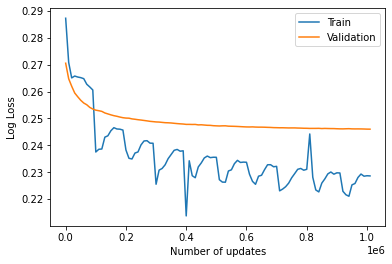

In [14]:
#Produce a plot of the losses
#ANSWER
import matplotlib.pyplot as plt
#from matplotlib.pyplot import figure
#figure(figsize=(4, 3), dpi=150) #Colab does only support inline display but you can change figure size with this

x = [10000*i for i in range(len(training_losses))]
plt.plot(x, training_losses, label='Train')
plt.plot(x, validation_losses, label='Validation')
plt.xlabel('Number of updates')
plt.ylabel('Log Loss')
plt.legend( ('Train', 'Validation') )
plt.show()
# overfitting, the bumps on the training loss are due to the reset after each epoch. => Not so good to reset the estimation of the loss  
#Log loss is ploted NCE is fine too (anyway this is only a rescaling)

5. Modify the code to enable the use of all quadratic features. This is doable only by modifying the function ```get_x``` 


In [15]:
#ANSWER with ony one vector for parameters. This is also possible to split the first and second order terms
def get_x(csv_row, D):
     x = []
     # normal features
     for key, value in csv_row.items():
         index = int(value + key[4:], 16) % D  
         x.append(index)
     # second order terms
     L = len(x)
     for i in range(L):
         for j in range(i+1, L):
             index = (x[i] * x[j]) % D  # second weakest hash
             x.append(index)

     # bias
     x.append(0)

     return x

4. After how many updates are you overfitting ? Same question after adding a L2 regularisation term with ponderation $5\cdot 10^{-4}$ and/or with a the learning rate of 0.01. (side question should we include the bias term in the regularization ?)



In [16]:
w = [0.] * D  
n = [0.] * D
loss = 0.
n_epochs = 10
n_updates = 0
training_losses = [] #To stores our training losses after each 10k updates 
validation_losses = [] #Same for validation

for e in range(n_epochs):
  training_loss = 0 #We reset to 0 the training at the begginning of each epoch to have a better idea of the current performance on the training set
  for t, (row, y)  in enumerate(zip(DictReader(open(X_train)), DictReader(open(y_train)))):
      x = get_x(row, D)
      p = get_p(x, w)
      target = float(y['click'])
      training_loss += logloss(p, target)
      if n_updates% 10000 == 0 and n_updates>1:
          training_losses.append( training_loss/t )
          validation_losses.append( compute_validation_loss(w, D) )
          print('%s\tupdates: %d\tcurrent logloss on train: %f\tcurrent logloss on validation: %f \tNCE in validation %f' % (
              datetime.now(), n_updates, training_losses[-1], validation_losses[-1], (Hy-validation_losses[-1])/Hy ))
      w, n = update_w(w, n, x, p, target)
      n_updates += 1

2022-01-05 19:07:41.132973	updates: 10000	current logloss on train: 0.291079	current logloss on validation: 0.269238 	NCE in validation 0.168801
2022-01-05 19:07:43.984228	updates: 20000	current logloss on train: 0.275756	current logloss on validation: 0.262381 	NCE in validation 0.189969
2022-01-05 19:07:46.874501	updates: 30000	current logloss on train: 0.270412	current logloss on validation: 0.261039 	NCE in validation 0.194110
2022-01-05 19:07:50.207657	updates: 40000	current logloss on train: 0.270709	current logloss on validation: 0.259100 	NCE in validation 0.200096
2022-01-05 19:07:53.651123	updates: 50000	current logloss on train: 0.269615	current logloss on validation: 0.259220 	NCE in validation 0.199727
2022-01-05 19:07:57.003344	updates: 60000	current logloss on train: 0.269340	current logloss on validation: 0.258151 	NCE in validation 0.203027
2022-01-05 19:08:00.168724	updates: 70000	current logloss on train: 0.268499	current logloss on validation: 0.256990 	NCE in valid

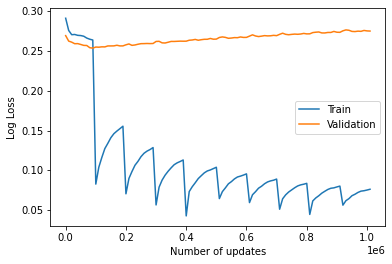

In [17]:
#Produce a plot of the losses
#ANSWER
x = [10000*i for i in range(len(training_losses))]
plt.plot(x, training_losses, label='Train')
plt.plot(x, validation_losses, label='Validation')
plt.xlabel('Number of updates')
plt.ylabel('Log Loss')
plt.legend( ('Train', 'Validation') )
plt.show()
#Clear overfitting.
#L2 regularization should help. Smaller step size will help in terms of number of updates but is possibly just slowing the process

2022-01-05 19:17:59.037243	updates: 10000	current logloss on train: 0.293971	current logloss on validation: 0.273741 	NCE in validation 0.154898
2022-01-05 19:18:02.524187	updates: 20000	current logloss on train: 0.275780	current logloss on validation: 0.266921 	NCE in validation 0.175952
2022-01-05 19:18:05.978243	updates: 30000	current logloss on train: 0.269094	current logloss on validation: 0.263435 	NCE in validation 0.186714
2022-01-05 19:18:09.241590	updates: 40000	current logloss on train: 0.269180	current logloss on validation: 0.260518 	NCE in validation 0.195721
2022-01-05 19:18:12.441093	updates: 50000	current logloss on train: 0.268300	current logloss on validation: 0.258844 	NCE in validation 0.200889
2022-01-05 19:18:15.969937	updates: 60000	current logloss on train: 0.267658	current logloss on validation: 0.257482 	NCE in validation 0.205092
2022-01-05 19:18:19.522128	updates: 70000	current logloss on train: 0.266939	current logloss on validation: 0.256303 	NCE in valid

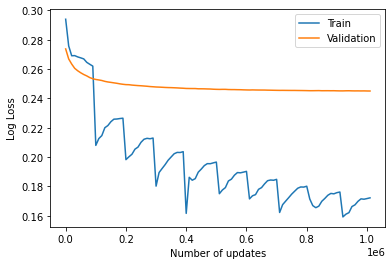

In [20]:
#ANSWER - same stuff with a L2 regularizer (bias term + quad terms)
#A lot of settings allows a large difference between train and validation, theses are indeed bad
#Remark than combining L1 and L2 is easy and is often named "elasticnet"
import matplotlib.pyplot as plt
import math

def update_wL2(w, n, x, p, y, lbd=5e-4):
    for i in x:
        # L2 reg added here. 
        w[i] -= ((p - y + lbd * 2 * w[i])  ) * alpha / (sqrt(n[i]) + 1.) 
        n[i] += 1.
    return w, n

sign = lambda x: math.copysign(1, x) #python has cumbersome sign function 
def update_wL1(w, n, x, p, y, lbd=5e-4):
    for i in x:
        w[i] -= ((p - y) * 2 + lbd * sign(w[i])) * alpha / (sqrt(n[i]) + 1.) 
        n[i] += 1.
    return w, n

D = 2 ** 24
w = [0.] * D  
n = [0.] * D
loss = 0.
n_epochs = 10
n_updates = 0
training_losses = [] 
validation_losses = [] 
alpha = .01 #CARE THE LEARNING RATE HAS BEEN MODIFIED 

for e in range(n_epochs):
  training_loss = 0
  for t, (row, y)  in enumerate(zip(DictReader(open(X_train)), DictReader(open(y_train)))):
      x = get_x(row, D)
      p = get_p(x, w)
      target = float(y['click'])
      training_loss += logloss(p, target)
      if n_updates% 10000 == 0 and n_updates>1:
          training_losses.append( training_loss/t )
          validation_losses.append( compute_validation_loss(w, D) )
          print('%s\tupdates: %d\tcurrent logloss on train: %f\tcurrent logloss on validation: %f \tNCE in validation %f' % (
              datetime.now(), n_updates, training_losses[-1], validation_losses[-1], (Hy-validation_losses[-1])/Hy ))
      w, n = update_wL2(w, n, x, p, target) #CODE UPDATED HERE 
      n_updates += 1

x = [10000*i for i in range(len(training_losses))]
plt.plot(x, training_losses, label='Train')
plt.plot(x, validation_losses, label='Validation')
plt.xlabel('Number of updates')
plt.ylabel('Log Loss')
plt.legend( ('Train', 'Validation') )
plt.show() 

wL2 = w #keep it for later use

#Depending on the learning rate and the coefficent in front of regularization this is possible 
#to have some overfitting advocating for early stopping. Remark that it does not hurt as hard the validation performance 
#Gains remains quite unclear, possibly due to the small dataset size   

2022-01-05 19:23:50.758967	updates: 10000	current logloss on train: 0.281518	current logloss on validation: 0.263934 	NCE in validation 0.185173
2022-01-05 19:23:54.440007	updates: 20000	current logloss on train: 0.265226	current logloss on validation: 0.257682 	NCE in validation 0.204475
2022-01-05 19:23:58.087391	updates: 30000	current logloss on train: 0.259635	current logloss on validation: 0.254862 	NCE in validation 0.213183
2022-01-05 19:24:01.766931	updates: 40000	current logloss on train: 0.260110	current logloss on validation: 0.252612 	NCE in validation 0.220127
2022-01-05 19:24:05.389149	updates: 50000	current logloss on train: 0.259491	current logloss on validation: 0.251746 	NCE in validation 0.222800
2022-01-05 19:24:09.112254	updates: 60000	current logloss on train: 0.259351	current logloss on validation: 0.250643 	NCE in validation 0.226207
2022-01-05 19:24:12.842958	updates: 70000	current logloss on train: 0.258849	current logloss on validation: 0.249833 	NCE in valid

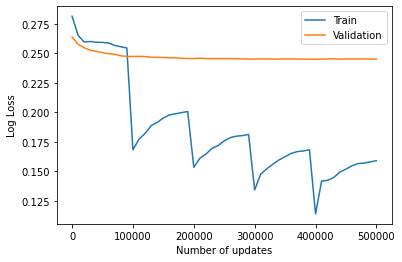

In [21]:
#Restart the main loop. This does not look as an optimal strategy. 
D = 2 ** 24
w = [0.] * D  
n = [0.] * D
loss = 0.
n_epochs = 5
n_updates = 0
training_losses = [] 
validation_losses = [] 
alpha = .01 

for e in range(n_epochs):
  training_loss = 0
  for t, (row, y)  in enumerate(zip(DictReader(open(X_train)), DictReader(open(y_train)))):
      x = get_x(row, D)
      p = get_p(x, w)
      target = float(y['click'])
      training_loss += logloss(p, target)
      if n_updates% 10000 == 0 and n_updates>1:
          training_losses.append( training_loss/t )
          validation_losses.append( compute_validation_loss(w, D) )
          print('%s\tupdates: %d\tcurrent logloss on train: %f\tcurrent logloss on validation: %f \tNCE in validation %f' % (
              datetime.now(), n_updates, training_losses[-1], validation_losses[-1], (Hy-validation_losses[-1])/Hy ))
      w, n = update_wL1(w, n, x, p, target) #CODE UPDATED HERE 
      n_updates += 1

x = [10000*i for i in range(len(training_losses))]
plt.plot(x, training_losses, label='Train')
plt.plot(x, validation_losses, label='Validation')
plt.xlabel('Number of updates')
plt.ylabel('Log Loss')
plt.legend( ('Train', 'Validation') )
plt.show() 

wL1 = w #keep it for later use


6. Plot an histogram of the values of the parameters without any regularization, with a L1 regularization and with a L2 one. If there is too many values in w you can subsample it. Can you explain the plots?



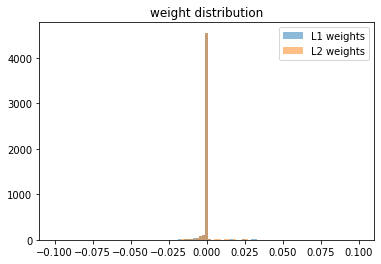

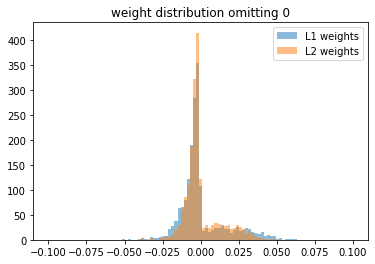

In [22]:
bins = np.linspace(-0.1, 0.1, 100)
plt.hist(wL1[:5000], bins, alpha=0.5, label='L1 weights')
plt.hist(wL2[:5000], bins, alpha=0.5, label='L2 weights')
plt.legend(loc='upper right')
plt.title('weight distribution')
plt.show()

#Indeed there is many zeros in the array (even more for L1 which is expected as it induces sparcity). 
#To have a resonnable plot we can remove them by
wL1_np = np.array(wL1)
wL2_np = np.array(wL2)
wL1_np[wL1_np==0]=np.nan
wL2_np[wL2_np==0]=np.nan
plt.hist(wL1_np[:20000], bins, alpha=0.5, label='L1 weights')
plt.hist(wL2_np[:20000], bins, alpha=0.5, label='L2 weights')
plt.legend(loc='upper right')
plt.title('weight distribution omitting 0')
plt.show()
#We observe a lot of small values for parameters which is typical of a large scale log reg with quad features and make them hard to interpret. 


8. Optimize the hyperparameters (the $L_1/L_2$ terms and the step size of the descent). Maybe this is time to use an external tool such as [Weight and Biases](https://wandb.ai/site) (the easy free for personal use path). It is possible to achieve the same results with  [Ray-Tune](https://docs.ray.io/en/latest/tune/index.html) combined with [MLflow](https://mlflow.org/) (the open source way).

Some documentation on hyperparamter tuning [here](https://docs.wandb.ai/guides/sweeps/python-api)

In [ ]:
#!pip install wandb
#!wandb login

In [ ]:
#import wandb
#Note that is exist the possiblity to create such config in a yaml file more info at https://docs.wandb.ai/guides/track/config
#This may be used to store the results of experiments (including models) in a common place
#Here we are going to create to config automatically thanks to a sweep but this is not the sole usage

sweep_config = {
  "name" : "TP1-ENSAE-hyperparameter_search",
  "method" : "random", #There exist several strategies such as Bayes and it possible to add some early stopping (see Hyperband). Care NCE is not a loss (higher is better)
  "parameters" : {
    "epochs" : {
      "values" : [1, 5, 10]
    },
    "learning_rate" :{
      "min": 0.0001,
      "max": 0.1
    },
    "l1":{
      "min": 0.,
      "max": 0.1
    },
    "l2":{
      "min": 0.,
      "max": 0.1
    },
  }
}
#sweep_id = wandb.sweep(sweep_config)


In [ ]:
def update_w_elastic(w, n, x, p, y, l1, l2, alpha):
    for i in x:
        w[i] -= (p - y + 2 * l2 * w[i] + l1*sign(w[i]) ) * alpha / (sqrt(n[i]) + 1.) 
        n[i] += 1.
    return w, n

def train():
  with wandb.init(reinit=True) as run:
    config = wandb.config
    D = 2 ** 24
    w = [0.] * D  
    n = [0.] * D
    loss = 0.
    n_updates = 0

    for e in range(config['epochs']):
      for t, (row, y)  in enumerate(zip(DictReader(open(X_train)), DictReader(open(y_train)))):
          x = get_x(row, D)
          p = get_p(x, w)
          target = float(y['click'])
          if n_updates% 10000 == 0 and n_updates>1:
              wandb.log({"loss": compute_validation_loss(w, D),
                         "epoch": e,
                         "n_updates":n_updates})
          w, n = update_w_elastic(w, n, x, p, target, config['l1'], config['l2'], config['learning_rate'])  
          n_updates += 1

count = 10 #Indeed the more the better and longer
#Using the same sweep_id it is also possible to distribute the training
#wandb.agent(sweep_id, function=train, count=count) 

9. Pick one or more kind of gradient descent in [this page ](https://ruder.io/optimizing-gradient-descent/index.html) and implement it (AdaGrad / Adam / [Nesterov's acceleration](https://jlmelville.github.io/mize/nesterov.html) / [SAGA](https://arxiv.org/pdf/1407.0202.pdf) are popular choices). Remark than even an averaged gradient descent will double the memory consuption and significantly increase the execution times in Python. 

In [24]:
#Let's go for Adam
#Unchecked code, just the minimal elements to insert at the right place in the code

#Adam hyperparameters
beta1 = 0.9
beta2 = 0.999
epsilon = 1e-8
alpha = 1e-2

def compute_gradient(p, y):
    #Easy to add L1/L2 penalizations if wanted
    return (p - y)

def update_w_adam(w, m, v, x, p, y):
    g = compute_gradient(p, y)
    for i in x:
        m[i] = beta1*m[i] + (1-beta1) * g
        v[i] = beta2*v[i] + (1-beta2) * g**2
        w[i] -= alpha/(sqrt(v[i])+epsilon) * m[i] 
    return w, m, v

#And in the main code include
m = [0.] * D
v = [0.] * D

w, m, v = update_w_adam(w, m, v, x, p, target) 


9. A possibility for relatively small datasets is to create a pipeline using sklearn a minimal implementation. Compare the results with the hand coded solution.  

In [27]:
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction import FeatureHasher
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import log_loss

X_train = np.loadtxt('../data/X_train.csv', skiprows=1, delimiter=',')
X_train = [[('%s' % _, 1) for _ in x] for x in X_train]
y_train = np.loadtxt('../data/y_train.csv', skiprows=1, delimiter=',').astype(np.int8)
y_train = y_train[:, 0] #select click data only

X_valid = np.loadtxt('../data/X_valid.csv', skiprows=1, delimiter=',')
X_valid = [[('%s' % _, 1) for _ in x] for x in X_valid]
y_valid = np.loadtxt('../data/y_valid.csv', skiprows=1, delimiter=',').astype(np.int8)
y_valid = y_valid[:, 0] 


# learn model
model = make_pipeline(FeatureHasher(n_features=2*6, input_type='pair'), 
                        PolynomialFeatures(2, interaction_only=False, include_bias=True),
                        #LogisticRegressionCV(n_jobs=4, Cs=10, solver='liblinear') #If you want to cross validate the regularization on train
                        LogisticRegression(solver='liblinear') #If you want a simple logistic regression
      )
model.fit(X_train, y_train)

#compute score in validation
y_hat_valid = model.predict_proba(X_valid)[:,1] #Output of logistic has as many columns than possible classes
print( f'Log loss on validation: {log_loss(y_valid, y_hat_valid)}') #CARE: the option "normalize" for log loss is not the NCE

Log loss on validation: 0.30510001101305634


Not that bad for some basic Python and SGD *versus* C++ code and a second order method. 

(optional since it can require long exe time) Can you recover the performance we had by optimizing hyperparameters? 

# Part II. Graded.

**Due date december 1st**
You can also send your answers to the optional questions 

1. Based on the minimal code example with validation and $L_2$ prenality, implement your own version of a factorization machine. As we do want to use fields this is the same than a rank k asumption on the matrix of the second order terms which can be expressed as $<v_i, v_j>$ with $v_i \in \mathbb{R}^k$ .  Remind that 
$$
\frac{\partial}{\partial \theta} \hat{y}(\mathbf{x})= \begin{cases}1, & \text { if } \theta \text { is } \mbox{the bias term } \omega_0 \\ x_{i}, & \text { if } \theta \text { is } w_{i} \mbox{ (first order term)} \\ x_{i} \sum_{j=1}^{n} v_{j, f} x_{j}-v_{i, f} x_{i}^{2}, & \text { if } \theta \text { is the } i,f \mbox { second order term } <v_i,v_f>   \end{cases}
$$

One possibility to code it is to isolate the second order term within a second vector of parameters while performing the ```get_x``` and change the way the gradient is computed in the ```update_x``` function. Details about factorization machines are in the [original paper](https://www.csie.ntu.edu.tw/~b97053/paper/Rendle2010FM.pdf).


In [ ]:
def get_x(csv_row, D):
     x = []
     # normal features
     for key, value in csv_row.items():
         index = int(value + key[4:], 16) % D  
         x.append(index)
     # second order terms
     L = len(x)
     for i in range(L):
         for j in range(i+1, L):
             index = (x[i] * x[j]) % D  # second weakest hash
             x.append(index)

     # bias
     x.append(0)

     return x

def update_wL2(w, n, x, p, y, lbd=5e-4):
    for i in x:
        # L2 reg added here. 
        w[i] -= ((p - y + lbd * 2 * w[i])  ) * alpha / (sqrt(n[i]) + 1.) 
        n[i] += 1.
    return w, n

2. Optimize the hyperparameters of a factorization machine for several dataset sizes and plot the resulting curve -- use the data contained in the test file to explore bigger than 100k training data size. For this question you can use a library such as [libFM](https://libfm.org). Remind that we already used the 10k first lines of the test data to build our validation set.


In [2]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

import numpy as np
from numba import njit
from tqdm import trange
from sklearn.base import BaseEstimator, ClassifierMixin

import pandas as pd

In [3]:
X_train = pd.read_csv('../data/X_train.csv')
X_test = pd.read_csv('../data/X_test.csv')

In [21]:
y_train = pd.read_csv('../data/y_train.csv')

In [22]:
y_train_trsm = y_train.click.to_numpy()

In [6]:
for i in range(19):
    print(i, np.unique(X_train.to_numpy()[:,i]).shape)

0 (9306,)
1 (9,)
2 (11,)
3 (586,)
4 (10,)
5 (2,)
6 (14,)
7 (14,)
8 (19,)
9 (9,)
10 (5636,)
11 (49,)
12 (3133,)
13 (103,)
14 (196399,)
15 (9,)
16 (847,)
17 (50896,)
18 (5,)


In [7]:
numerical = (0, 3, 10, 12, 14, 16, 17)
numerical_features = [f'hash_{i}' for i in numerical]
categorical_features = [f'hash_{i}' for i in range(19) if i not in numerical]

numerical_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())])
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)])

In [8]:
X_train_trsm = preprocessor.fit_transform(X_train)

In [9]:
X_test_trsm = preprocessor.transform(X_test)

In [27]:
class FactorizationMachineClassifier(BaseEstimator, ClassifierMixin):
    """
    Factorization Machine [1]_ using Stochastic Gradient Descent.
    For binary classification only.

    Parameters
    ----------
    n_iter : int, default 10
        Number of iterations to train the algorithm.

    n_factors : int, default 10
        Number/dimension of features' latent factors.

    learning_rate : float, default 0.1
        Learning rate for the gradient descent optimizer.

    reg_coef : float, default 0.01
        Regularization strength for weights/coefficients.

    reg_factors : float, default 0.01
        Regularization strength for features' latent factors.

    random_state : int, default 1234
        Seed for the randomly initialized features latent factors

    verbose : bool, default True
        Whether to print progress bar while training.

    Attributes
    ----------
    intercept_ : double
        Intercept term, w0 based on the original notations.

    coef_ : 1d ndarray, shape [n_features,]
        Coefficients, w based on the original notations.

    feature_factors_ : 2d ndarray, shape [n_factors, n_features]
        Latent factors for all features. v based on the original
        notations. The learned factors can be viewed as the
        embeddings for each features. If a pair of features tends
        to co-occur often, then their embeddings should be
        close/similar (in terms of cosine similarity) to each other.

    history_ : list
        Loss function's history at each iteration, useful
        for evaluating whether the algorithm converged or not.

    References
    ----------
    .. [1] `S. Rendle Factorization Machines (2010)
            <http://www.csie.ntu.edu.tw/~b97053/paper/Rendle2010FM.pdf>`_ 
    """

    def __init__(self, n_iter = 10, n_factors = 10,
                 learning_rate = 0.1, reg_coef = 0.01,
                 reg_factors = 0.01, random_state = 1234, verbose = False):
        self.n_iter = n_iter
        self.verbose = verbose
        self.reg_coef = reg_coef
        self.n_factors = n_factors
        self.reg_factors = reg_factors
        self.random_state = random_state
        self.learning_rate = learning_rate

    def fit(self, X, y):
        """
        Fit the model to the input data and label.

        Parameters
        ----------
        X : scipy sparse csr_matrix, shape [n_samples, n_features]
            Data in sparse matrix format.

        y : 1d ndarray, shape [n_samples,]
            Training data's corresponding label.

        Returns
        -------
        self
        """

        n_samples, n_features = X.shape
        self.coef_ = np.zeros(n_features)
        self.intercept_ = 0.0

        # the factors are often initialized with a mean of 0 and standard deviation
        # of 1 / sqrt(number of latent factor specified)
        np.random.seed(self.random_state)
        self.feature_factors_ = np.random.normal(
            scale = 1 / np.sqrt(self.n_factors), size = (self.n_factors, n_features))
        
        # the gradient is implemented in a way that requires
        # the negative class to be labeled as -1 instead of 0
        y = y.copy().astype(np.int32)
        y[y == 0] = -1

        loop = range(self.n_iter)
        if self.verbose:
            loop = trange(self.n_iter)

        self.history_ = []
        for _ in loop:
            loss = _sgd_update(X.data, X.indptr, X.indices,
                               y, n_samples, n_features,
                               self.intercept_, self.coef_,
                               self.feature_factors_, self.n_factors,
                               self.learning_rate, self.reg_coef, self.reg_factors)
            self.history_.append(loss)

        return self

    def predict_proba(self, X):
        """
        Probability estimates. The returned estimates for
        all classes are ordered by the label of classes.

        Paramters
        ---------
        X : scipy sparse csr_matrix, shape [n_samples, n_features]
            Data in sparse matrix format.

        Returns
        -------
        proba : 2d ndarray, shape [n_samples, n_classes]
            The probability of the sample for each class in the model.
        """
        pred = self._predict(X)
        pred_proba = 1.0 / (1.0 + np.exp(-pred))
        proba = np.vstack((1 - pred_proba, pred_proba)).T
        return proba

    def _predict(self, X):
        """Similar to _predict_instance but vectorized for all samples"""
        linear_output = X * self.coef_
        v = self.feature_factors_.T
        term = (X * v) ** 2 - (X.power(2) * (v ** 2))
        factor_output = 0.5 * np.sum(term, axis = 1)
        return self.intercept_ + linear_output + factor_output

    def predict(self, X):
        """
        Predict class labels for samples in X.

        Parameters
        ----------
        X : scipy sparse csr_matrix, shape [n_samples, n_features]
            Data in sparse matrix format.

        Returns
        -------
        Predicted class label per sample.
        """
        pred_proba = self.predict_proba(X)[:, 1]
        return pred_proba.round().astype(np.int)


@njit
def _sgd_update(data, indptr, indices, y, n_samples, n_features,
                w0, w, v, n_factors, learning_rate, reg_w, reg_v):
    """
    Compute the loss of the current iteration and update
    gradients accordingly.
    """
    loss = 0.0
    for i in range(n_samples):
        pred, summed = _predict_instance(data, indptr, indices, w0, w, v, n_factors, i)
        
        # calculate loss and its gradient
        loss += _log_loss(pred, y[i])
        loss_gradient = -y[i] / (np.exp(y[i] * pred) + 1.0)
    
        # update bias/intercept term
        w0 -= learning_rate * loss_gradient

        # update weight
        for index in range(indptr[i], indptr[i + 1]):
            feature = indices[index]
            w[feature] -= learning_rate * (loss_gradient * data[index] + 2 * reg_w * w[feature])

        # update factor
        for factor in range(n_factors):
            for index in range(indptr[i], indptr[i + 1]):
                feature = indices[index]
                term = summed[factor] - v[factor, feature] * data[index]
                v_gradient = loss_gradient * data[index] * term
                v[factor, feature] -= learning_rate * (v_gradient + 2 * reg_v * v[factor, feature])
    
    loss /= n_samples
    return loss


@njit
def _predict_instance(data, indptr, indices, w0, w, v, n_factors, i):
    """predicting a single instance"""
    summed = np.zeros(n_factors)
    summed_squared = np.zeros(n_factors)

    # linear output w * x
    pred = w0
    for index in range(indptr[i], indptr[i + 1]):
        feature = indices[index]
        pred += w[feature] * data[index]

    # factor output
    for factor in range(n_factors):
        for index in range(indptr[i], indptr[i + 1]):
            feature = indices[index]
            term = v[factor, feature] * data[index]
            summed[factor] += term
            summed_squared[factor] += term * term

        pred += 0.5 * (summed[factor] * summed[factor] - summed_squared[factor])
    
    # summed is the independent term that can be re-used
    # during the gradient update stage
    return pred, summed


@njit
def _log_loss(pred, y):
    """
    negative log likelihood of the
    current prediction and label, y.
    """
    #return np.clip(np.log(np.exp(-pred * y) + 1.0), 1e-12, 1e12)
    return np.log(np.exp(-pred * y) + 1.0)

In [28]:
fm = FactorizationMachineClassifier(n_iter = 30, learning_rate = 0.1)
fm.fit(X_train_trsm, y_train_trsm)

FactorizationMachineClassifier(n_iter=30)

In [30]:
import matplotlib.pyplot as plt

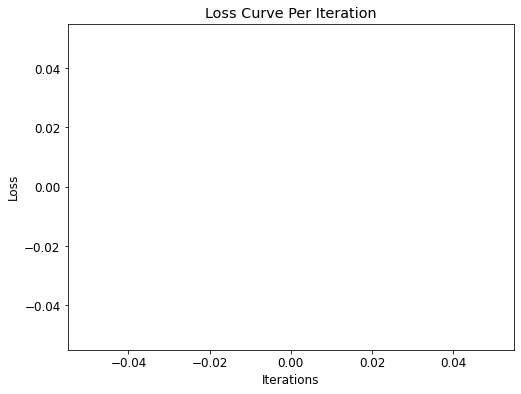

In [31]:
# change default style figure and font size
plt.rcParams['figure.figsize'] = 8, 6
plt.rcParams['font.size'] = 12

# one quick way to check that we've implemented
# the gradient descent is to ensure that the loss
# curve is steadily decreasing
plt.plot(fm.history_)
plt.title('Loss Curve Per Iteration')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

In [32]:
fm.history_

[nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan]